In [2]:
import os
import pandas as pd
import matplotlib
import numpy as np
from matplotlib.ticker import FuncFormatter
from kernels.wrapper import MODELS, KernelModelWrapper
from dataset.ipc2023_learning_domain_info import IPC2023_LEARNING_DOMAINS, get_test_ipc2023_learning_instance_files, get_best_bound
from itertools import product
from IPython.display import display, HTML
from util.scrape_log import scrape_search_log
from util.visualise import *

In [3]:
# _PAPER_DIR=str(Path.home())+"/papers/manuscripts/24-icaps-kernels"
_PAPER_DIR=str(Path.home())+"/papers/manuscripts/genplan-23-kernels"

In [4]:
pd.options.display.float_format = "{:.1f}".format

In [5]:
_LOG_DIR = "logs/test_ipc2023"
_DIFFICULTIES = ["easy", "medium", "hard"]
_MODELS = [
  "blind",
  "hff",
  # "lama-seq",
#   "lama-first",
  "muninn", 
  "goose", 
  # "linear-regression",
  "ridge", 
  "lasso", 
  "linear-svr", 
  "quadratic-svr", 
  "cubic-svr",
  "rbf-svr", 
  "mlp", 
]

KERNELS = {"ridge", "lasso", "linear-svr", "quadratic-svr", "cubic-svr", "rbf-svr", "mlp"}
CLASSICAL = {"blind", "hff", "lama-first"}

In [6]:
def get_data(domain):
  data = {
  }

  test_files = get_test_ipc2023_learning_instance_files()

  for model in _MODELS:
    d = {
      "solved": [],
      "expanded": [],
      "cost": [],
      "first_h": [],
      "quality": [],
      "c_opt": [],
      "difficulty": [],
      "time": [],
    }

    for difficulty in _DIFFICULTIES:
      for df, pf in test_files[domain]:
        if not difficulty in pf:
          continue
        pf_name = os.path.basename(pf).replace(".pddl", "")

        if model=="muninn":
          stats = {
            "first_h": -1,
            "solved": 0,
            "time": -1,
            "cost": -1,
            "expanded": -1,
            "evaluated": -1,
          }

          log_file = f"logs/logs_muninn/{domain}_{difficulty}_{pf_name}_domain-knowledge-{domain}.dk.log"
        
          if not os.path.exists(log_file):
            continue

          """
          [1] Subplan: 10, Heuristic: 9.998 -> goal, Expanded: 22, Generated: 86 (260 ms)
          Writing file "plan.1" (10 actions)
          Planned for 0 minutes and 0 seconds
          """

          for line in open(log_file, 'r').readlines():
            if "[1]" in line and stats['solved'] == 0:
              toks = line.replace(",", "").replace("(", "").split()
              stats["first_h"] = float(toks[4])
            if "Writing file" in line:
              toks = line.replace(",", "").replace("(", "").split()
              stats["cost"] = int(toks[-2])
              stats["solved"] = 1
        else:
          if model=="goose":
            dd = {
              "easy": "0",
              "medium": "1",
              "hard": "2",
            }[difficulty]
            log_file = f"logs/gnn_ipc2023_test/{domain}:p-{dd}-{pf_name.replace('p', '')}:goose_fd.log"
            assert os.path.exists(log_file), log_file
          elif model in KERNELS:
                log_file = f"logs/opt_ipc2023_test/{domain}_{difficulty}_{pf_name}_-scratch-sv11-dc6693-trained_models_kernel-opt_{model}_ig_{domain}_wl_1_0.joblib.log"
                # assert os.path.exists(log_file), log_file
          else:
            log_file = f"logs/ipc2023_{model}/{domain}_{difficulty}_{pf_name}_{model}.log"
        
          if not os.path.exists(log_file):
            continue

          stats = scrape_search_log(log_file)

        for k in d:
          if k in stats:
            d[k].append(stats[k])
            
        c = stats["cost"] if stats["solved"] else -1
        c_opt = get_best_bound(domain, difficulty, pf_name)
        quality = c_opt / c
        quality = max(quality, 0)
        quality = min(quality, 1)
        d["quality"].append(quality)
        d["c_opt"].append(c_opt)
        d["difficulty"].append(difficulty)
        
    data[model] = d

  return data

In [29]:
def get_metrics_df(data):
  d = {
    "config": [],
    "quality": [],
    "solved": [],
    "tried": [],
    "e_quality": [],
    "e_solved": [],
    "e_tried": [],
    "m_quality": [],
    "m_solved": [],
    "m_tried": [],
    "h_quality": [],
    "h_solved": [],
    "h_tried": [],
  }
  for config in _MODELS:
    d["config"].append(config)
    d["quality"].append(sum(data[config]["quality"]))
    d["solved"].append(sum(data[config]["solved"]))
    d["tried"].append(len(data[config]["solved"]))
    for difficulty in _DIFFICULTIES:
      quality = 0
      solved = 0
      tried = 0
      for i, prob_solved in enumerate(data[config]["solved"]):
        if data[config]["difficulty"][i] == difficulty:
          quality += data[config]["quality"][i]
          solved += prob_solved
          tried += 1
      d[f"{difficulty[0]}_quality"].append(quality)
      d[f"{difficulty[0]}_solved"].append(solved)
      d[f"{difficulty[0]}_tried"].append(tried)
  return pd.DataFrame(d)

In [8]:
def get_table_df(easy_only=False):
  d = {
    "domain": [],
  }
  for config in _MODELS:
    d[config] = []

  sum_scores = {config: 0 for config in _MODELS}

  for domain in IPC2023_LEARNING_DOMAINS:
    data = get_data(domain)
    d["domain"].append(domain)

    for config in _MODELS:
      if easy_only:
        score = 0
        for i, quality in enumerate(data[config]["quality"]):
          if data[config]["difficulty"][i] == "easy":
            score += quality
      else:
        score = sum(data[config]["quality"])
      d[config].append(score)
      sum_scores[config] += score
  

  d["domain"].append("sum")
  for config in _MODELS:
    d[config].append(sum_scores[config])

  return pd.DataFrame(d)

In [9]:
for domain in IPC2023_LEARNING_DOMAINS:
  print(domain)
  data = get_data(domain)
  display(get_metrics_df(data))

blocksworld
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,blind,8.0,8,90,8.0,8,30,0.0,0,30,0,0,30
1,hff,14.1,28,90,14.1,28,30,0.0,0,30,0,0,30
2,muninn,39.0,39,90,30.0,30,30,9.0,9,30,0,0,30
3,goose,23.9,29,90,23.0,28,30,0.9,1,30,0,0,30
4,ridge,10.8,18,60,10.8,18,30,0.0,0,30,0,0,0
5,lasso,6.3,7,60,6.3,7,30,0.0,0,30,0,0,0
6,linear-svr,8.4,15,60,8.4,15,30,0.0,0,30,0,0,0
7,quadratic-svr,11.1,23,60,11.1,23,30,0.0,0,30,0,0,0
8,cubic-svr,7.2,17,60,7.2,17,30,0.0,0,30,0,0,0
9,rbf-svr,10.5,17,60,10.5,17,30,0.0,0,30,0,0,0


childsnack
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,blind,9.0,9,90,9.0,9,30,0,0,30,0,0,30
1,hff,20.1,26,90,20.1,26,30,0,0,30,0,0,30
2,muninn,11.0,11,90,11.0,11,30,0,0,30,0,0,30
3,goose,8.7,10,90,8.7,10,30,0,0,30,0,0,30
4,ridge,13.9,18,60,13.9,18,30,0,0,30,0,0,0
5,lasso,9.0,9,60,9.0,9,30,0,0,30,0,0,0
6,linear-svr,17.2,18,60,17.2,18,30,0,0,30,0,0,0
7,quadratic-svr,12.5,13,60,12.5,13,30,0,0,30,0,0,0
8,cubic-svr,18.7,20,60,18.7,20,30,0,0,30,0,0,0
9,rbf-svr,17.2,18,60,17.2,18,30,0,0,30,0,0,0


ferry
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,blind,10.0,10,90,10.0,10,30,0.0,0,30,0,0,30
1,hff,67.6,68,90,29.6,30,30,30.0,30,30,8,8,30
2,muninn,46.0,46,90,30.0,30,30,16.0,16,30,0,0,30
3,goose,59.7,60,90,29.7,30,30,30.0,30,30,0,0,30
4,ridge,38.3,45,90,25.9,30,30,12.4,15,30,0,0,30
5,lasso,60.6,61,90,29.6,30,30,30.0,30,30,1,1,30
6,linear-svr,73.6,74,90,29.6,30,30,30.0,30,30,14,14,30
7,quadratic-svr,73.6,74,90,29.6,30,30,30.0,30,30,14,14,30
8,cubic-svr,56.8,57,90,29.8,30,30,27.0,27,30,0,0,30
9,rbf-svr,25.7,26,90,23.7,24,30,2.0,2,30,0,0,30


floortile
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,blind,2.0,2,90,2.0,2,30,0,0,30,0,0,30
1,hff,11.2,12,90,11.2,12,30,0,0,30,0,0,30
2,muninn,0.0,0,90,0.0,0,30,0,0,30,0,0,30
3,goose,0.9,1,90,0.9,1,30,0,0,30,0,0,30
4,ridge,1.8,2,60,1.8,2,30,0,0,30,0,0,0
5,lasso,1.8,2,60,1.8,2,30,0,0,30,0,0,0
6,linear-svr,1.8,2,60,1.8,2,30,0,0,30,0,0,0
7,quadratic-svr,0.9,1,60,0.9,1,30,0,0,30,0,0,0
8,cubic-svr,0.9,1,60,0.9,1,30,0,0,30,0,0,0
9,rbf-svr,0.0,0,60,0.0,0,30,0,0,30,0,0,0


miconic
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,blind,30.0,30,90,30.0,30,30,0,0,30,0.0,0,30
1,hff,88.5,90,90,28.7,30,30,30,30,30,29.9,30,30
2,muninn,30.0,30,90,30.0,30,30,0,0,30,0.0,0,30
3,goose,72.0,73,90,29.1,30,30,30,30,30,12.9,13,30
4,ridge,28.2,30,60,28.2,30,30,0,0,30,0.0,0,0
5,lasso,29.9,30,60,29.9,30,30,0,0,30,0.0,0,0
6,linear-svr,29.8,31,60,28.8,30,30,1,1,30,0.0,0,0
7,quadratic-svr,28.5,30,60,28.5,30,30,0,0,30,0.0,0,0
8,cubic-svr,28.7,30,60,28.7,30,30,0,0,30,0.0,0,0
9,rbf-svr,28.5,30,60,28.5,30,30,0,0,30,0.0,0,0


rovers
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,blind,15.0,15,90,15.0,15,30,0.0,0,30,0,0,30
1,hff,32.7,34,90,27.7,29,30,5.0,5,30,0,0,30
2,muninn,14.2,15,90,14.2,15,30,0.0,0,30,0,0,30
3,goose,17.7,20,90,17.7,20,30,0.0,0,30,0,0,30
4,ridge,23.4,31,60,22.7,30,30,0.7,1,30,0,0,0
5,lasso,19.0,20,60,19.0,20,30,0.0,0,30,0,0,0
6,linear-svr,20.1,29,60,20.1,29,30,0.0,0,30,0,0,0
7,quadratic-svr,22.4,29,60,21.4,28,30,1.0,1,30,0,0,0
8,cubic-svr,21.2,28,60,20.5,27,30,0.7,1,30,0,0,0
9,rbf-svr,20.5,25,60,20.5,25,30,0.0,0,30,0,0,0


satellite
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,blind,12.0,12,90,12.0,12,30,0,0,30,0,0,30
1,hff,63.8,65,90,28.8,30,30,30,30,30,5,5,30
2,muninn,18.0,18,90,16.0,16,30,2,2,30,0,0,30
3,goose,24.1,29,90,22.1,27,30,2,2,30,0,0,30
4,ridge,4.6,10,60,4.6,10,30,0,0,30,0,0,0
5,lasso,36.3,38,60,28.3,30,30,8,8,30,0,0,0
6,linear-svr,35.7,45,60,20.7,30,30,15,15,30,0,0,0
7,quadratic-svr,25.3,29,60,22.3,26,30,3,3,30,0,0,0
8,cubic-svr,25.3,29,60,25.3,29,30,0,0,30,0,0,0
9,rbf-svr,19.8,24,60,19.8,24,30,0,0,30,0,0,0


sokoban
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,blind,27.0,27,90,27.0,27,30,0.0,0,30,0,0,30
1,hff,26.3,36,90,23.2,30,30,3.1,6,30,0,0,30
2,muninn,25.2,27,90,25.2,27,30,0.0,0,30,0,0,30
3,goose,26.7,30,90,25.7,29,30,1.0,1,30,0,0,30
4,ridge,34.8,38,60,26.9,30,30,8.0,8,30,0,0,0
5,lasso,25.7,26,60,25.7,26,30,0.0,0,30,0,0,0
6,linear-svr,34.8,38,60,26.9,30,30,8.0,8,30,0,0,0
7,quadratic-svr,30.2,33,60,27.3,30,30,2.9,3,30,0,0,0
8,cubic-svr,28.1,31,60,27.1,30,30,1.0,1,30,0,0,0
9,rbf-svr,27.6,30,60,27.6,30,30,0.0,0,30,0,0,0


spanner
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,blind,30.0,30,90,30.0,30,30,0,0,30,0,0,30
1,hff,30.0,30,90,30.0,30,30,0,0,30,0,0,30
2,muninn,32.0,32,90,30.0,30,30,2,2,30,0,0,30
3,goose,29.6,30,90,29.6,30,30,0,0,30,0,0,30
4,ridge,25.9,30,60,25.9,30,30,0,0,30,0,0,0
5,lasso,26.3,30,60,26.3,30,30,0,0,30,0,0,0
6,linear-svr,25.9,30,60,25.9,30,30,0,0,30,0,0,0
7,quadratic-svr,25.9,30,60,25.9,30,30,0,0,30,0,0,0
8,cubic-svr,26.2,30,60,26.2,30,30,0,0,30,0,0,0
9,rbf-svr,25.9,30,60,25.9,30,30,0,0,30,0,0,0


transport
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,blind,9.0,9,90,9.0,9,30,0.0,0,30,0,0,30
1,hff,39.3,41,90,28.3,30,30,11.0,11,30,0,0,30
2,muninn,17.0,17,90,17.0,17,30,0.0,0,30,0,0,30
3,goose,29.0,31,90,27.0,29,30,2.0,2,30,0,0,30
4,ridge,23.9,29,60,22.2,27,30,1.7,2,30,0,0,0
5,lasso,32.2,33,60,29.2,30,30,3.0,3,30,0,0,0
6,linear-svr,26.1,31,60,23.0,27,30,3.0,4,30,0,0,0
7,quadratic-svr,26.3,29,60,26.3,29,30,0.0,0,30,0,0,0
8,cubic-svr,25.2,28,60,25.2,28,30,0.0,0,30,0,0,0
9,rbf-svr,22.2,24,60,22.2,24,30,0.0,0,30,0,0,0


In [10]:
scores_df = get_table_df()
scores = scores_df.to_numpy()
scores = scores[:,1:]
display(scores_df)

,domain,blind,hff,muninn,goose,ridge,lasso,linear-svr,quadratic-svr,cubic-svr,rbf-svr,mlp
0,blocksworld,8.0,14.1,39.0,23.9,10.8,6.3,8.4,11.1,7.2,10.5,5.9
1,childsnack,9.0,20.1,11.0,8.7,13.9,9.0,17.2,12.5,18.7,17.2,14.4
2,ferry,10.0,67.6,46.0,59.7,38.3,60.6,73.6,73.6,56.8,25.7,67.6
3,floortile,2.0,11.2,0.0,0.9,1.8,1.8,1.8,0.9,0.9,0.0,0.9
4,miconic,30.0,88.5,30.0,72.0,28.2,29.9,29.8,28.5,28.7,28.5,28.9
5,rovers,15.0,32.7,14.2,17.7,23.4,19.0,20.1,22.4,21.2,20.5,18.7
6,satellite,12.0,63.8,18.0,24.1,4.6,36.3,35.7,25.3,25.3,19.8,23.9
7,sokoban,27.0,26.3,25.2,26.7,34.8,25.7,34.8,30.2,28.1,27.6,33.9
8,spanner,30.0,30.0,32.0,29.6,25.9,26.3,25.9,25.9,26.2,25.9,25.9
9,transport,9.0,39.3,17.0,29.0,23.9,32.2,26.1,26.3,25.2,22.2,27.4


In [11]:
""" scores.tex """
scores_df = get_table_df()
scores = scores_df.to_numpy()
scores = scores[:,1:]
scores_easy = get_table_df(easy_only=True).to_numpy()[:,1:]
ret  = r"\begin{tabular}{" + "c " + " ".join(["p{\qualitywidth}" for _ in range(len(_MODELS))]) + r"} \toprule Domain "
for model in _MODELS:
  ret += f"& \\header{{\{model.replace('-', '')}}} "
ret += r"\\ \midrule" + '\n'

for domain, scores_domain in zip(IPC2023_LEARNING_DOMAINS, scores):
  ret += domain
  sorted_scores_domain = sorted(scores_domain, reverse=True)
  sorted_scores_domain = [round(x, 1) for x in sorted_scores_domain]
  for score in scores_domain:
    score = round(score, 1)
    if score==0:
      ret += f" & -"
    elif score==sorted_scores_domain[0]:
      ret += f" & \\first{{{score:.1f}}}"
    elif score==sorted_scores_domain[1]:
      ret += f" & \\second{{{score:.1f}}}"
    elif score==sorted_scores_domain[2]:
      ret += f" & \\third{{{score:.1f}}}"
    else:
      ret += f" & {score:.1f}"
  ret += "\\\\ \n"

ret += "\midrule  sum"
sorted_scores_domain = sorted(scores[-1], reverse=True)
sorted_scores_domain = [round(x, 1) for x in sorted_scores_domain]
for score in scores[-1]:
    score = round(score, 1)
    if score==0:
      ret += f" & -"
    elif score==sorted_scores_domain[0]:
      ret += f" & \\first{{{score:.1f}}}"
    elif score==sorted_scores_domain[1]:
      ret += f" & \\second{{{score:.1f}}}"
    elif score==sorted_scores_domain[2]:
      ret += f" & \\third{{{score:.1f}}}"
    else:
      ret += f" & {score:.1f}"
ret += "\\\\"

ret += "\midrule  \\emph{improvement}"
for score_sum, score_easy in zip(scores[-1], scores_easy[-1]):
  ret += f" & \\emph{{+{score_sum - score_easy:.1f}}}"
ret += "\\\\"

ret += r"\bottomrule\end{tabular}"

f = open(f"{_PAPER_DIR}/figures/scores.tex", 'w')
f.write(ret)
f.close()

In [12]:
""" scores_easy.tex """
scores_df = get_table_df(easy_only=True)
scores = scores_df.to_numpy()
scores = scores[:,1:]
ret  = r"\begin{tabular}{" + " ".join(["c" for _ in range(len(_MODELS)+1)]) + r"} \toprule Domain "
for model in _MODELS:
  ret += f"& \\header{{\{model.replace('-', '')}}} "
ret += r"\\ \midrule" + '\n'

for domain, scores_domain in zip(IPC2023_LEARNING_DOMAINS, scores):
  ret += domain
  best_score = max(scores_domain)
  for score in scores_domain:
    if score==best_score:
      ret += f" & \\textbf{{{score:.1f}}}"
    else:
      ret += f" & {score:.1f}"
  ret += "\\\\ \n"

ret += "\midrule  sum"
best_score = max(scores[-1])
for score in scores[-1]:
    if score==best_score:
      ret += f" & \\textbf{{{score:.1f}}}"
    else:
      ret += f" & {score:.1f}"
ret += "\\\\"

ret += r"\bottomrule\end{tabular}"

f = open(f"{_PAPER_DIR}/figures/scores_easy.tex", 'w')
f.write(ret)
f.close()

In [13]:
""" coverage2.tex """

scores_df = get_table_df()
scores = scores_df.to_numpy()
scores = scores[:,1:]

ret  = r"\begin{tabular}{" + " ".join(["c" for _ in range(len(_MODELS)+1)]) + r"} \toprule Domain "
# ret  = r"\begin{tabular}{" + "c " + " ".join(["p{\coveragewidth}" for _ in range(len(_MODELS))]) + r"} \toprule Domain "

for model in _MODELS:
    ret += f"& \\header{{\{model.replace('-', '')}}} "
ret += r"\\ \midrule" + '\n'

all_solved = {
  "easy": np.zeros(len(_MODELS)),
  "medium": np.zeros(len(_MODELS)),
  "hard": np.zeros(len(_MODELS)),
  "all": np.zeros(len(_MODELS)),
}

for domain, scores_domain in zip(IPC2023_LEARNING_DOMAINS, scores):
  ret += f"\\multirow{{2}}{{*}}{{{domain}}}"
  data = (get_metrics_df(get_data(domain)).to_numpy())
  solved = {
    "easy": data[:,5].T,
    "medium": data[:,8].T,
    "hard": data[:,11].T,
  }

  for i in range(len(solved["easy"])):
    chunks = []
    for difficulty in solved:

      scores_domain = solved[difficulty]
      if i==0:
        all_solved[difficulty] += scores_domain
      best_score = max(scores_domain)
      score = solved[difficulty][i]
      if score == 0:
        chunks.append("-")
      elif score==best_score:
        chunks.append(f"\\textbf{{{score}}}")
      else:
        chunks.append(f"{score}")

    chunk = "/".join(chunks)
    ret += f" & {chunk}"
  ret += "\\\\ \n"

  solved = {
    "all": data[:,2].T,
  }

  for i in range(len(solved["all"])):
    chunks = []
    for difficulty in solved:

      scores_domain = solved[difficulty]
      if i==0:
        all_solved[difficulty] += scores_domain
      best_score = max(scores_domain)
      score = solved[difficulty][i]
      if score == 0:
        chunks.append("-")
      elif score==best_score:
        chunks.append(f"\\textbf{{{score}}}")
      else:
        chunks.append(f"{score}")

    chunk = "/".join(chunks)
    ret += f" & {chunk}"
  
  if domain==IPC2023_LEARNING_DOMAINS[-1]:
    ret += "\\\\ \midrule \n"
  else:
    ret += "\\\\ \cmidrule(lr){2-" + str(len(_MODELS)+1) + "} \n"

ret += f"\\multirow{{2}}{{*}}{{sum}}"
for i in range(len(all_solved["all"])):
    chunks = []
    for difficulty in ["easy", "medium", "hard"]:

        scores_domain = all_solved[difficulty]
        best_score = max(scores_domain)
        score = all_solved[difficulty][i]
        print(score, best_score)
        if score == 0:
          chunks.append("-")
        elif score==best_score:
          chunks.append(f"\\textbf{{{score}}}")
        else:
          chunks.append(f"{score}")

    chunk = "/".join(chunks)
    ret += f" & {chunk}"

ret += r" \\ "

for i in range(len(all_solved["all"])):
    chunks = []
    for difficulty in ["all"]:

        scores_domain = all_solved[difficulty]
        best_score = max(scores_domain)
        score = all_solved[difficulty][i]
        print(score, best_score)
        if score == 0:
          chunks.append("-")
        elif score==best_score:
          chunks.append(f"\\textbf{{{score}}}")
        else:
          chunks.append(f"{score}")

    chunk = "/".join(chunks)
    ret += f" & {chunk}"

ret += r" \\ \bottomrule\end{tabular}"

f = open(f"{_PAPER_DIR}/figures/coverage2.tex", 'w')
f.write(ret)
f.close()

easy 90
medium 90
hard 90
easy 90
medium 90
hard 90
easy 90
medium 90
hard 90
easy 90
medium 90
hard 90
easy 90
medium 90
hard 90
easy 90
medium 90
hard 90
easy 90
medium 90
hard 90
easy 90
medium 90
hard 90
easy 90
medium 90
hard 90
easy 90
medium 90
hard 90
152 275
0 112
0 43
275 275
112 112
43 43
206 275
29 112
0 43
234 275
66 112
13 43
225 275
26 112
0 43
214 275
41 112
1 43
241 275
58 112
14 43
240 275
37 112
14 43
242 275
29 112
0 43
222 275
2 112
0 43
231 275
43 112
8 43
152 430
430 430
235 430
313 430
251 430
256 430
313 430
291 430
271 430
224 430
282 430


In [42]:
""" quality_and_coverage.tex """

scores_df = get_table_df()
scores = scores_df.to_numpy()
scores = scores[:,1:]

ret  = r"\begin{tabular}{ c " + " ".join(["p{\\bigtablewidth}" for _ in range(4*len(_MODELS))]) + r"} \toprule Domain "
# ret  = r"\begin{tabular}{" + "c " + " ".join(["p{\coveragewidth}" for _ in range(len(_MODELS))]) + r"} \toprule Domain "

for model in _MODELS:
    ret += f"& \\headermulti{{\{model.replace('-', '')}}} "
ret += r"\\ \midrule" + '\n'

all_solved = {
  "easy": np.zeros(len(_MODELS)).astype(int),
  "medium": np.zeros(len(_MODELS)).astype(int),
  "hard": np.zeros(len(_MODELS)).astype(int),
  "all": np.zeros(len(_MODELS)).astype(int),
}
all_quality = {
  "easy": np.zeros(len(_MODELS)),
  "medium": np.zeros(len(_MODELS)),
  "hard": np.zeros(len(_MODELS)),
  "all": np.zeros(len(_MODELS)),
}

for domain in IPC2023_LEARNING_DOMAINS:
    ret += f"\\multirow{{2}}{{*}}{{{domain}}}"
    data = (get_metrics_df(get_data(domain)).to_numpy())

    # coverage then cost
    for nnn, solved in enumerate([
        {
        "easy": data[:,5].T,
        "medium": data[:,8].T,
        "hard": data[:,11].T,
        "all": data[:,2].T,
    },
    {
        "easy": data[:,4].T,
        "medium": data[:,7].T,
        "hard": data[:,10].T,
        "all": data[:,1].T,
    }
    ]):

        for i in range(len(solved["easy"])):
            chunks = []
            for difficulty in ["easy", "medium", "hard", "all"]:

                scores_domain = solved[difficulty]
                if i==0:
                    if nnn == 0:
                        all_solved[difficulty] += scores_domain.astype(int)
                    if nnn == 1:
                        all_quality[difficulty] += scores_domain.astype(int)
                best_score = max(scores_domain)
                score = solved[difficulty][i]
                if nnn == 0:
                    if score == 0:
                        chunks.append("-")
                    elif score==best_score:
                        chunks.append(f"\\textbf{{{score}}}")
                    else:
                        chunks.append(f"{score}")
                else:
                    if score == 0:
                        chunks.append("-")
                    elif score==best_score:
                        chunks.append(f"\\textbf{{{score:.1f}}}")
                    else:
                        chunks.append(f"{score:.1f}")

            chunk = " & ".join(chunks)
            ret += f" & {chunk}"

        if nnn == 1:
            if domain==IPC2023_LEARNING_DOMAINS[-1]:
                ret += "\\\\ \midrule \n"
            else:
                ret += "\\\\ \cmidrule(lr){2-" + str(4*len(_MODELS)+1) + "} \n"
        else:
            ret += "\\\\ \n"

# ret += f"\\multirow{{2}}{{*}}{{sum}}"
# for i in range(len(all_solved["all"])):
#     chunks = []
#     for difficulty in ["easy", "medium", "hard"]:

#         scores_domain = all_solved[difficulty]
#         best_score = max(scores_domain)
#         score = all_solved[difficulty][i]
#         if score == 0:
#           chunks.append("-")
#         elif score==best_score:
#           chunks.append(f"\\textbf{{{score}}}")
#         else:
#           chunks.append(f"{score}")

#     chunk = " & ".join(chunks)
#     ret += f" & {chunk}"

# ret += r" \\ "

# for i in range(len(all_solved["all"])):
#     chunks = []
#     for difficulty in ["all"]:

#         scores_domain = all_solved[difficulty]
#         best_score = max(scores_domain)
#         score = all_solved[difficulty][i]
#         if score == 0:
#           chunks.append("-")
#         elif score==best_score:
#           chunks.append(f"\\textbf{{{score}}}")
#         else:
#           chunks.append(f"{score}")

#     chunk = " & ".join(chunks)
#     ret += f" & {chunk}"

ret += r" \\ \bottomrule\end{tabular}"

f = open(f"{_PAPER_DIR}/figures/quality_and_coverage.tex", 'w')
f.write(ret)
f.close()

In [65]:
""" coverage_tall.tex """
nnn = 0

scores_df = get_table_df()
scores = scores_df.to_numpy()
scores = scores[:,1:]

# ret  = r"\begin{tabular}{ c " + " ".join(["c" for _ in range(4*len(_MODELS))]) + r"} \toprule Domain "
ret  = r"\begin{tabular}{" + "c " + " ".join(["p{\coveragewidth}" for _ in range(len(_MODELS))]) + r"} \toprule Domain "

for model in _MODELS:
    ret += f"& \\header{{\{model.replace('-', '')}}} "
ret += r"\\ \midrule" + '\n'

all_solved = {
  "easy": np.zeros(len(_MODELS)).astype(int),
  "medium": np.zeros(len(_MODELS)).astype(int),
  "hard": np.zeros(len(_MODELS)).astype(int),
  "all": np.zeros(len(_MODELS)).astype(int),
}
all_quality = {
  "easy": np.zeros(len(_MODELS)),
  "medium": np.zeros(len(_MODELS)),
  "hard": np.zeros(len(_MODELS)),
  "all": np.zeros(len(_MODELS)),
}

for domain in IPC2023_LEARNING_DOMAINS:
    ret += f"\\multirow{{4}}{{*}}{{{domain}}}"
    data = (get_metrics_df(get_data(domain)).to_numpy())

    # coverage then cost
    solved = {
        "easy": data[:,5].T,
        "medium": data[:,8].T,
        "hard": data[:,11].T,
        "all": data[:,2].T,
    }

    for difficulty in ["easy", "medium", "hard", "all"]:
        scores_domain = solved[difficulty]
        sorted_scores_domain = sorted(scores_domain, reverse=True)
        all_solved[difficulty] += np.array(scores_domain).astype(int)
        for i in range(len(solved["easy"])):
            chunks = []
            best_score = max(scores_domain)
            score = solved[difficulty][i]
            if score == 0:
                chunks.append("-")
            elif score==sorted_scores_domain[0]:
                chunks.append(f"\\first{{{score}}}")
            elif score==sorted_scores_domain[1]:
                chunks.append(f"\\second{{{score}}}")
            elif score==sorted_scores_domain[2]:
                chunks.append(f"\\third{{{score}}}")
            else:
                chunks.append(f"{score}")

            chunk = " & ".join(chunks)
            ret += f" & {chunk}"

        if difficulty != "all":
            ret += "\\\\ \n"

    if domain==IPC2023_LEARNING_DOMAINS[-1]:
        ret += "\\\\ \midrule \n"
    else:
        ret += "\\\\ \cmidrule(lr){2-" + str(len(_MODELS)+1) + "} \n"

ret += f"\\multirow{{4}}{{*}}{{sum}}"

for difficulty in ["easy", "medium", "hard", "all"]:
    for i in range(len(all_solved["easy"])):
        chunks = []

        scores_domain = all_solved[difficulty]

        sorted_scores_domain = sorted(scores_domain, reverse=True)
        sorted_scores_domain = [round(x, 1) for x in sorted_scores_domain]
        best_score = max(scores_domain)
        score = all_solved[difficulty][i]
        if score == 0:
            chunks.append("-")
        elif score==sorted_scores_domain[0]:
            chunks.append(f"\\first{{{score}}}")
        elif score==sorted_scores_domain[1]:
            chunks.append(f"\\second{{{score}}}")
        elif score==sorted_scores_domain[2]:
            chunks.append(f"\\third{{{score}}}")
        else:
            chunks.append(f"{score}")

        chunk = " & ".join(chunks)
        ret += f" & {chunk}"

    if difficulty != "all":
        ret += "\\\\ \n"

ret += r" \\ \bottomrule\end{tabular}"

f = open(f"{_PAPER_DIR}/figures/coverage_tall.tex", 'w')
f.write(ret)
f.close()

In [67]:
""" quality_tall.tex """
nnn = 1

scores_df = get_table_df()
scores = scores_df.to_numpy()
scores = scores[:,1:]

# ret  = r"\begin{tabular}{ c " + " ".join(["c" for _ in range(4*len(_MODELS))]) + r"} \toprule Domain "
ret  = r"\begin{tabular}{" + "c " + " ".join(["p{\coveragewidth}" for _ in range(len(_MODELS))]) + r"} \toprule Domain "

for model in _MODELS:
    ret += f"& \\header{{\{model.replace('-', '')}}} "
ret += r"\\ \midrule" + '\n'
all_quality = {
  "easy": np.zeros(len(_MODELS)).astype(float),
  "medium": np.zeros(len(_MODELS)).astype(float),
  "hard": np.zeros(len(_MODELS)).astype(float),
  "all": np.zeros(len(_MODELS)).astype(float),
}

for domain in IPC2023_LEARNING_DOMAINS:
    ret += f"\\multirow{{4}}{{*}}{{{domain}}}"
    data = (get_metrics_df(get_data(domain)).to_numpy())

    # coverage then cost
    solved = {
        "easy": data[:,4].T,
        "medium": data[:,7].T,
        "hard": data[:,10].T,
        "all": data[:,1].T,
    }

    for difficulty in ["easy", "medium", "hard", "all"]:
        scores_domain = solved[difficulty]
        sorted_scores_domain = sorted(scores_domain, reverse=True)
        sorted_scores_domain = [round(x, 1) for x in sorted_scores_domain]
        all_quality[difficulty] += np.array(scores_domain).astype(float)
        for i in range(len(solved["easy"])):
            chunks = []
            score = solved[difficulty][i]
            score = round(score, 1)
            if score == 0:
                chunks.append("-")
            elif score==sorted_scores_domain[0]:
                chunks.append(f"\\first{{{score:.1f}}}")
            elif score==sorted_scores_domain[1]:
                chunks.append(f"\\second{{{score:.1f}}}")
            elif score==sorted_scores_domain[2]:
                chunks.append(f"\\third{{{score:.1f}}}")
            else:
                chunks.append(f"{score:.1f}")

            chunk = " & ".join(chunks)
            ret += f" & {chunk}"

        if difficulty != "all":
            ret += "\\\\ \n"

    if domain==IPC2023_LEARNING_DOMAINS[-1]:
        ret += "\\\\ \midrule \n"
    else:
        ret += "\\\\ \cmidrule(lr){2-" + str(len(_MODELS)+1) + "} \n"

ret += f"\\multirow{{4}}{{*}}{{sum}}"
all_solved = all_quality
for difficulty in ["easy", "medium", "hard", "all"]:
    scores_domain = all_solved[difficulty]
    sorted_scores_domain = sorted(scores_domain, reverse=True)
    sorted_scores_domain = [round(x, 1) for x in sorted_scores_domain]
    for i in range(len(all_solved["easy"])):
        chunks = []
        score = all_solved[difficulty][i]
        score = round(score, 1)
        if score == 0:
            chunks.append("-")
        elif score==sorted_scores_domain[0]:
            chunks.append(f"\\first{{{score:.1f}}}")
        elif score==sorted_scores_domain[1]:
            chunks.append(f"\\second{{{score:.1f}}}")
        elif score==sorted_scores_domain[2]:
            chunks.append(f"\\third{{{score:.1f}}}")
        else:
            chunks.append(f"{score:.1f}")

        chunk = " & ".join(chunks)
        ret += f" & {chunk}"

    if difficulty != "all":
        ret += "\\\\ \n"

ret += r" \\ \bottomrule\end{tabular}"

f = open(f"{_PAPER_DIR}/figures/quality_tall.tex", 'w')
f.write(ret)
f.close()

In [15]:
os.makedirs(f"{_PAPER_DIR}/plots", exist_ok=True)

In [16]:
""" costs """
assert 0
for domain in IPC2023_LEARNING_DOMAINS:
  print(domain)
  data = get_data(domain)
  plt.axvline(30, c='k', alpha=0.75, ls="--")
  plt.axvline(60, c='k', alpha=0.75, ls="--")
  for model in _MODELS:
    xs = []
    ys = []
    for i, expanded in enumerate(data[model]["cost"]):
      if expanded!=-1:
        xs.append(i)
        ys.append(expanded)
    if model in CLASSICAL:
      marker = 'x'
    else:
      marker = 'o'
    plt.scatter(xs, ys, label=model, marker=marker, alpha=0.75)
  plt.yscale("log")
  plt.xlim(right=90)
  plt.legend(loc=(1.1, 0))
  plt.title(domain)
  # plt.show()
  plt.savefig(f"{_PAPER_DIR}/plots/cost_{domain}.png", bbox_inches="tight")
  plt.clf()

blocksworld
childsnack
ferry
floortile
miconic
rovers
satellite
sokoban
spanner
transport


<Figure size 640x480 with 0 Axes>

In [17]:
""" expansions """
assert 0

for domain in IPC2023_LEARNING_DOMAINS:
  print(domain)
  data = get_data(domain)
  plt.axvline(30, c='k', alpha=0.75, ls="--")
  plt.axvline(60, c='k', alpha=0.75, ls="--")
  for model in _MODELS:
    xs = []
    ys = []
    for i, expanded in enumerate(data[model]["expanded"]):
      if expanded!=-1:
        xs.append(i)
        ys.append(expanded)
    if model in CLASSICAL:
      marker = 'x'
    else:
      marker = 'o'
    plt.scatter(xs, ys, label=model, marker=marker, alpha=0.75)
  plt.yscale("log")
  plt.xlim(right=90)
  plt.legend(loc=(1.1, 0))
  plt.title(domain)
  # plt.show()
  plt.savefig(f"{_PAPER_DIR}/plots/expanded_{domain}.png", bbox_inches="tight")
  plt.clf()

blocksworld
childsnack
ferry
floortile
miconic
rovers
satellite
sokoban
spanner
transport


<Figure size 640x480 with 0 Axes>

In [73]:
""" expansions and costs (svr vs GOOSE + svr vs FF) """
x_model = "linear-svr"
SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 40

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
def format_exponential(value, pos):
    return f"$10^{{{int(np.log10(value))}}}$"

formatter = FuncFormatter(format_exponential)

for metric, maxx in [("expanded", 5e8), ("cost", 5e4)]:
    for y_model in ["goose", "hff"]:
        plt.plot([1, maxx], [1, maxx], c='k', linestyle='--')
        for domain in IPC2023_LEARNING_DOMAINS:
            data = get_data(domain)

            xs = []
            ys = []
            for i, expanded in enumerate(data[x_model][metric]):
                expanded = expanded if expanded != -1 else maxx
                xs.append(expanded)
            for i, expanded in enumerate(data[y_model][metric]):
                expanded = expanded if expanded != -1 else maxx
                ys.append(expanded)
            for _ in range(90-len(xs)):
                xs.append(maxx)
            for _ in range(90-len(ys)):
                ys.append(maxx)
            plt.scatter(xs, ys, label=domain, alpha=0.75)
        
        plt.xscale("log")
        plt.yscale("log")
        plt.xlim((1, maxx))
        plt.ylim((1, maxx))
        # plt.legend(loc=(1.1, 0))
        plt.gca().set_aspect('equal')
        plt.ylabel(y_model)
        # if y_model=="goose":
        #     plt.xlabel(x_model)
        #     if maxx==5e8:
        #         plt.xticks([1e0, 1e2, 1e4, 1e6, 1e8])
        #         plt.gca().get_xaxis().set_major_formatter(formatter)
        #     else:
        #         plt.xticks([1e0, 1e1, 1e2, 1e3, 1e4])
        #         plt.gca().get_xaxis().set_major_formatter(formatter)
        # else:
        #     plt.xticks([])

        plt.xlabel(x_model)
        if maxx==5e8:
            plt.xticks([1e0, 1e4, 1e8])
            plt.gca().get_xaxis().set_major_formatter(formatter)
        else:
            plt.xticks([1e0, 1e2, 1e4])
            plt.gca().get_xaxis().set_major_formatter(formatter)

        matplotlib.rcParams['xtick.minor.size'] = 0
        matplotlib.rcParams['xtick.minor.width'] = 0
        matplotlib.rcParams['ytick.minor.size'] = 0
        matplotlib.rcParams['ytick.minor.width'] = 0
        plt.title(metric)
        # plt.show()
        plt.savefig(f"{_PAPER_DIR}/plots/{metric}_{y_model}_vs_{x_model}.pdf", bbox_inches="tight")
        plt.clf()

<Figure size 640x480 with 0 Axes>

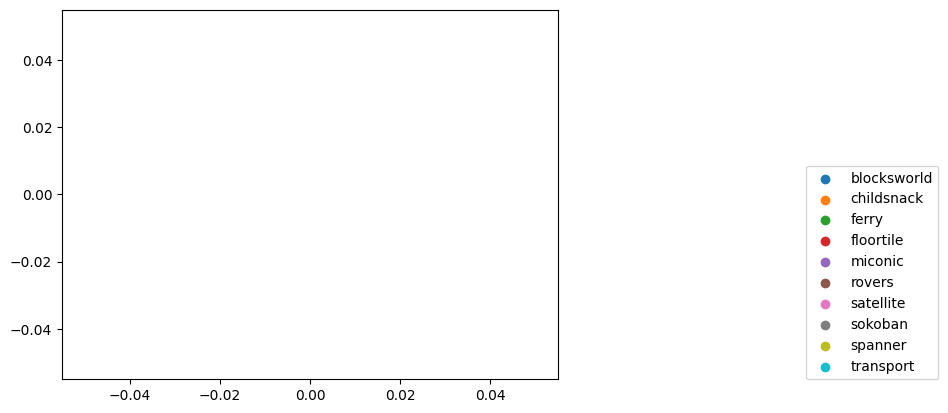

In [19]:
# """ just legend """
# assert 0
# for domain in IPC2023_LEARNING_DOMAINS:
#     plt.scatter([],[],label=domain)
# # Display the legend
# plt.legend(loc=(1.5,0))
# plt.savefig(f"{_PAPER_DIR}/plots/legend.pdf", bbox_inches="tight")

In [20]:
""" cumulative runtime """
assert 0
for domain in IPC2023_LEARNING_DOMAINS:
  print(domain)
  data = get_data(domain)
  for model in _MODELS:
    ys = []
    for i, runtime in enumerate(data[model]["time"]):
      if runtime!=-1:
        ys.append(runtime)
    ys += []
    plt.hist(ys, cumulative=True, histtype='step', label=model)
#   plt.xlim(left=0, right=1800)
  plt.xscale("log")
  plt.legend(loc=(1.1, 0))
  plt.title(domain)
  # plt.show()
  plt.savefig(f"{_PAPER_DIR}/plots/cumulative_{domain}.png", bbox_inches="tight")
  plt.clf()

blocksworld
childsnack
ferry
floortile
miconic
rovers
satellite
sokoban
spanner
transport


<Figure size 640x480 with 0 Axes>

In [21]:
os.makedirs("plots", exist_ok=True)
for domain in IPC2023_LEARNING_DOMAINS:
  try:
    data = get_data(domain)

    max_val = 0

    for config in CONFIGS:
      cs = np.array(data[config]["cost"])
      c_opts = np.array(data[config]["c_opt"])
      index = np.where(cs != -1)
      cs = cs[index]
      c_opts = c_opts[index]
      plt.scatter(c_opts, cs, label="_".join(config))
      max_val = max([max_val, max(cs), max(c_opts)])
    
    plt.title(domain)
    plt.plot([1, max_val], [1, max_val], alpha=0.5, linestyle="dotted", c='k')
    plt.ylabel("C")
    plt.xlabel("C* (not necessarily optimal)")
    plt.legend()
    # plt.show()
    plt.savefig(f"plots/{_REP}_cost_ipc2023-learning-{domain}.png")
  except:
    pass
  plt.clf()
print("c vs c* saved")

c vs c* saved


<Figure size 640x480 with 0 Axes>

NameError: name 'CONFIGS' is not defined

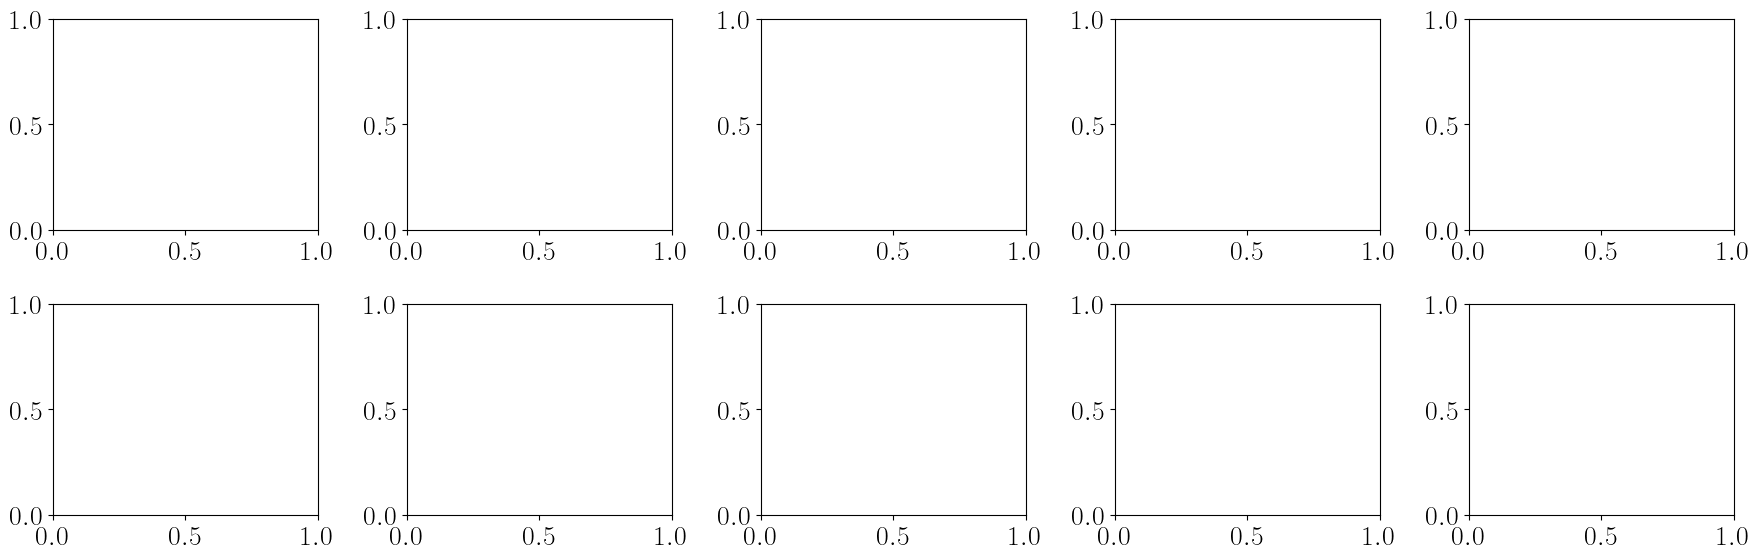

In [22]:
plt.rcParams.update({
  "text.usetex": True,
  "font.size": 20,
})

fig, axs = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=False, figsize=(18, 6))
fig.tight_layout()

for k, domain in enumerate(IPC2023_LEARNING_DOMAINS):
  i = k // 5
  j = k % 5
  data = get_data(domain)
  max_val = 0

  for config in ["muninn"] + CONFIGS:
    cs = np.array(data[config]["cost"])
    c_opts = np.array(data[config]["c_opt"])
    index = np.where(cs != -1)
    cs = cs[index]
    c_opts = c_opts[index]
    label = "Muninn" if config == "muninn" else config[0]
    if config=="muninn":
      marker='*'
    elif "svr" in config[0]:
      marker='x'
    else:
      marker='o'
    axs[i,j].scatter(c_opts, cs, label=label, alpha=0.6, marker=marker)
    try:
      max_val = max([max_val, max(cs), max(c_opts)])
    except:
      pass
  
  axs[i,j].plot([1, max_val], [1, max_val], alpha=0.5, linestyle="dotted", c='k')
  axs[i,j].set_title(domain)

plt.legend(loc=(1.1, 0.5))
plt.savefig(f"{_PAPER_DIR}/figures/cost.pdf", bbox_inches="tight")
plt.show()

In [ ]:
os.makedirs("plots", exist_ok=True)
for domain in IPC2023_LEARNING_DOMAINS:
  try:
    data = get_data(domain)

    max_val = 0

    my_dict = {}

    fig, ax = plt.subplots()

    for config in CONFIGS:
      expanded = np.array(data[config]["expanded"])
      # index = np.where(expanded != -1)
      expanded = expanded[index]
      my_dict["_".join(config)] = expanded
    
    plt.yscale("log")
    plt.title(domain)
    ax.boxplot(my_dict.values())
    ax.set_xticklabels(my_dict.keys())
    # plt.ylim(bottom=1)
    # plt.show()
    plt.savefig(f"plots/{_REP}_expanded_ipc2023-learning-{domain}.png")
  except:
    pass
  plt.clf()
print("expansions saved")